### Conversion Rate - Improve Revenue

The goal of this challenge is to build a model that predicts conversion rate and, based on the model, come up with ideas to improve revenue.

We have data about users who hit the site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site). 

The project is to: 
Predict conversion rate 
Come up with recommendations for the product team and the marketing team to improve conversion rate 

### Data Description

##### Columns: 

# Recommendations - Based on Analysis and Visaulizations

# Recommendations - Based on Predictive Model

As you can see, conclusions usually end up being about:
1. tell marketing to get more of the good performing user segments
2. tell product to fix the experience for the bad performing ones

# Code

In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score,f1_score, roc_curve,auc,accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [68]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Read Data
conversions_df=pd.read_csv("conversion_rate_Q1.csv")

#### Summarize Data

In [4]:
conversions_df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [5]:
conversions_df.shape

(316200, 6)

In [6]:
conversions_df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [7]:
conversions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


#### Visualization

What is the conversion rate?

In [8]:
#Observation count by label
conversions_df.converted.value_counts()

0    306000
1     10200
Name: converted, dtype: int64

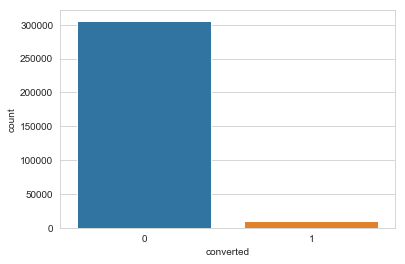

In [9]:
#Plot label category count
sns.countplot(conversions_df.converted);

In [11]:
#Conversion Rate
conversion_rate=round((conversions_df[conversions_df.converted==1].size/conversions_df.converted.size)*100,2)
print("Conversion Rate = ",conversion_rate, "%")

Conversion Rate =  19.35 %


conversion rate at around 3% is industry standard. It makes sense. Something wrong here? should be 3.23%? Come back later

In [26]:
con_rate=(conversions_df.converted.value_counts()/conversions_df.converted.size)*100
con_rate

0    96.774194
1     3.225806
Name: converted, dtype: float64

********************************************************************************************************************************

How is the sample geographically distributed?

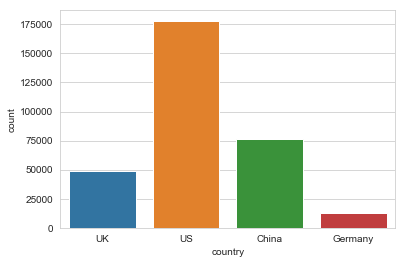

In [12]:
#Plot observation count by country
sns.countplot(conversions_df.country);

In [25]:
#User Rate by Country
country_rate=(conversions_df.country.value_counts()/conversions_df.country.size)*100
country_rate

US         56.322581
China      24.225806
UK         15.322581
Germany     4.129032
Name: country, dtype: float64

**********************************************************************************

What is the conversion rate in each country?

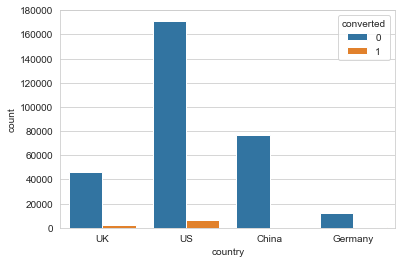

In [27]:
#Plot observation count by country and converted
sns.countplot(conversions_df.country, hue=conversions_df.converted);

In [28]:
#Calculate conversion rate by country
countryconversion_rate=conversions_df[conversions_df['converted']==1].country.value_counts()/conversions_df.country.value_counts()
countryconversion_rate

China      0.001332
Germany    0.062500
UK         0.052632
US         0.037801
Name: country, dtype: float64

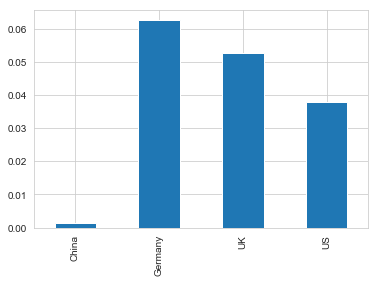

In [30]:
countryconversion_rate.plot('bar');

Germany has the highest conversion rate

***********************************************************************************************

Which marketing channel gives highest conversion rate?

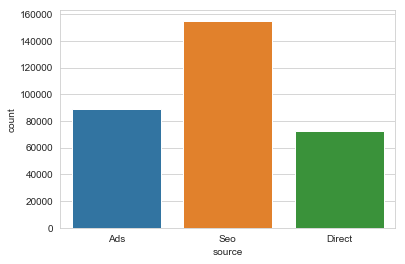

In [31]:
#Plot observation count by Marketing channel
sns.countplot(conversions_df.source);

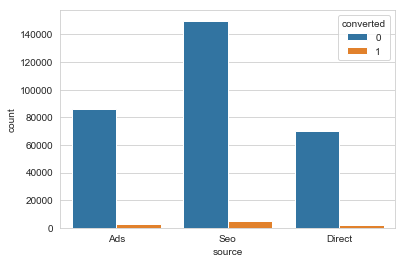

In [32]:
#Plot observation count by Marketing channel and converted
sns.countplot(conversions_df.source, hue=conversions_df.converted);

In [33]:
#Calculate marketing channel conversion rate
sourceconversion_rate=conversions_df[conversions_df['converted']==1].source.value_counts()/conversions_df.source.value_counts()
sourceconversion_rate

Seo       0.032895
Ads       0.034483
Direct    0.028169
Name: source, dtype: float64

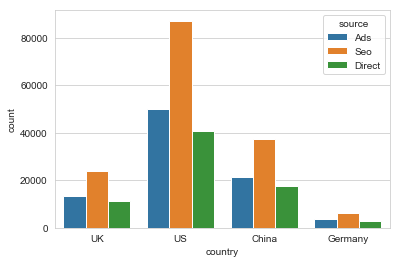

In [34]:
#Conversion Rate - Marketing Channel by Country
sns.countplot(conversions_df.country, hue=conversions_df.source);

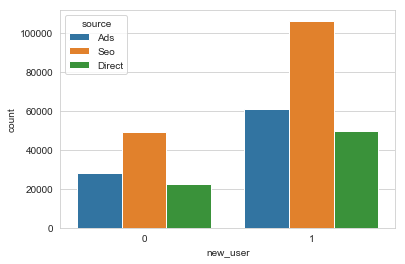

In [35]:
#Conversion Rate - Marketing Channel by Use
sns.countplot(conversions_df.new_user, hue=conversions_df.source);

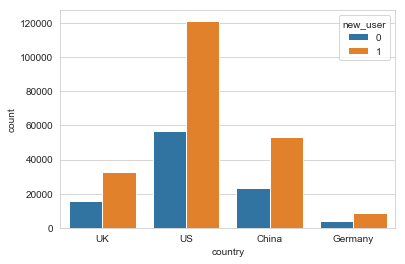

In [36]:
#Conversion Rate - Use by Country
sns.countplot(conversions_df.country, hue=conversions_df.new_user);

*********************************************************************************************************

Is conversion higher among new users or established users?

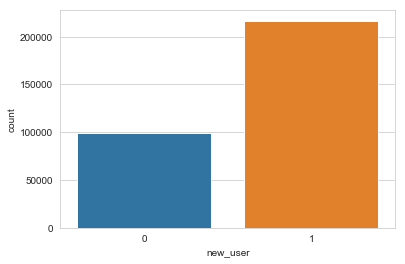

In [37]:
#Plot observation count by user type
sns.countplot(conversions_df.new_user);

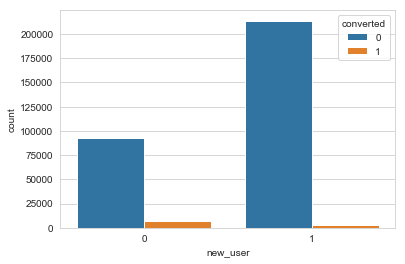

In [38]:
#Plot observation count by user type and conversion
sns.countplot(conversions_df.new_user,hue=conversions_df.converted);

In [39]:
#Calculate user type conversion rate
userconversion_rate=conversions_df[conversions_df['converted']==1].new_user.value_counts()/conversions_df.new_user.value_counts()
userconversion_rate

0    0.072002
1    0.014021
Name: new_user, dtype: float64

Conversion rate of returning users are significantly higher than the new users. We have to explore why we have a low conversion among new users.

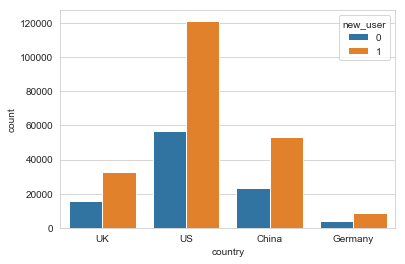

In [40]:
#What is the new user rate among countries
#Plot observation count by user type and country
sns.countplot(conversions_df.country,hue=conversions_df.new_user);

******************************************************************************************

What is the distribution of age groups in the dataset?

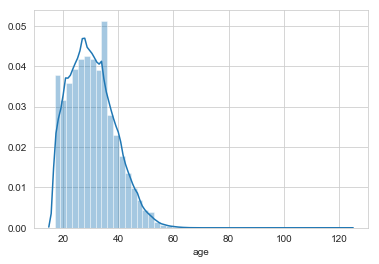

In [41]:
#Plot histogram of age
sns.distplot(conversions_df.age);

In [42]:
#Binning:
def binning(col, cut_points, labels=None):
  #Define min and max values:
  minval = col.min()
  maxval = col.max()

  #create list by adding min and max to cut_points
  break_points = [minval] + cut_points + [maxval]

  #if no labels provided, use default labels 0 ... (n-1)
  if not labels:
    labels = range(len(cut_points)+1)

  #Binning using cut function of pandas
  colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
  return colBin
#Binning age:
cut_points = [20,25,30,35,40]
labels = ["Less Than 20","20-25","25-30","30-35","35-40","Greater Than 40"]
conversions_df["age_group"] = binning(conversions_df["age"], cut_points, labels)

In [43]:
conversions_df.head()

,country,age,new_user,source,total_pages_visited,converted,age_group
0,UK,25,1,Ads,1,0,20-25
1,US,23,1,Seo,5,0,20-25
2,US,28,1,Seo,4,0,25-30
3,China,39,1,Seo,5,0,35-40
4,US,30,1,Seo,6,0,25-30


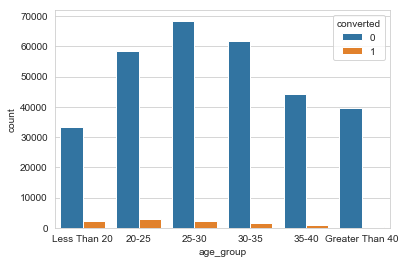

In [44]:
#Age Group - Conversion
sns.countplot(conversions_df.age_group,hue=conversions_df.converted);

In [46]:
#Age Group - Conversion HOW TO FILTER OUT not converted????
sns.countplot(conversions_df.age_group,hue=conversions_df.converted);

KeyError: False

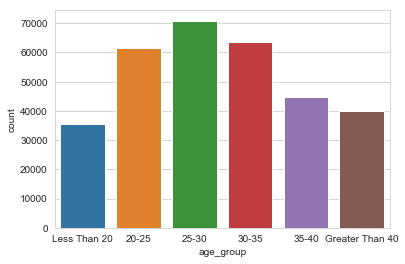

In [50]:
sns.countplot(conversions_df.age_group);

In [47]:
#Age Group - Conversion rate 
ageconversion_rate=conversions_df[conversions_df['converted']==1].age_group.value_counts()/conversions_df.age_group.value_counts()*100
ageconversion_rate

20-25              4.750663
25-30              3.365792
30-35              2.343516
35-40              1.703076
Greater Than 40    1.037924
Less Than 20       6.272492
Name: age_group, dtype: float64

There is a high conversion rate in age groups less than 30. Market to this base.

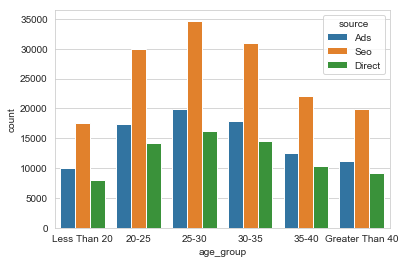

In [51]:
#Age Group - by Source 
sns.countplot(conversions_df.age_group,hue=conversions_df.source);

In [52]:
# Conversion by age group and source
pd.crosstab(conversions_df[conversions_df['converted']==1].age_group,conversions_df[conversions_df['converted']==1].source).apply(lambda x:x/x.sum())*100

source,Ads,Direct,Seo
age_group,,,
Less Than 20,21.862745,20.882353,22.274510
20-25,29.477124,29.117647,27.882353
25-30,22.385621,23.235294,24.039216
30-35,14.607843,14.362745,14.627451
35-40,7.549020,8.480392,7.058824
Greater Than 40,4.117647,3.921569,4.117647


Age by Source - Conversation Rate doesnt show a variation by source. Within an age group the sources have the same conversion rate.

In [53]:
#Age Group by New User
pd.crosstab(conversions_df[conversions_df['converted']==1].age_group,conversions_df[conversions_df['converted']==1].new_user).apply(lambda x:x/x.sum())*100

new_user,0,1
age_group,,
Less Than 20,21.868454,21.882198
20-25,28.557464,28.726555
25-30,23.725737,22.573215
30-35,14.439324,14.873314
35-40,7.512917,7.436657
Greater Than 40,3.896104,4.508062


In [54]:
#Age Group by Country
pd.crosstab(conversions_df[conversions_df['converted']==1].age_group,conversions_df[conversions_df['converted']==1].country).apply(lambda x:x/x.sum())*100

country,China,Germany,UK,US
age_group,,,,
Less Than 20,20.588235,23.406863,22.431373,21.494355
20-25,31.372549,26.593137,28.392157,28.891860
25-30,27.450980,23.529412,23.882353,23.113488
30-35,16.666667,14.950980,14.196078,14.631610
35-40,0.980392,7.843137,7.137255,7.679739
Greater Than 40,2.941176,3.676471,3.960784,4.188948


***************************************************************************************************************

How many pages does a user visit in a session?

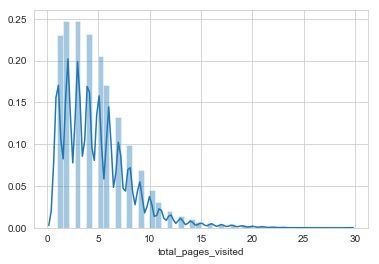

In [55]:
#Plot histogram of total_pages_visited
sns.distplot(conversions_df.total_pages_visited);

*******************************************************************

In [56]:
correlation=conversions_df.corr()

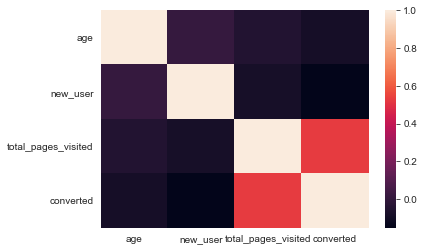

In [57]:
sns.heatmap(correlation);

****************************************************************************

#### Remove Outliers

In [58]:
conversions_df=conversions_df[conversions_df.age<=90]
conversions_df.shape

(316198, 7)

#### Data Preprocessing

In [59]:
#Get dummies for categorical variables use One-Hot encoder 
conversions_df=pd.get_dummies(conversions_df)
conversions_df.head()

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo,age_group_Less Than 20,age_group_20-25,age_group_25-30,age_group_30-35,age_group_35-40,age_group_Greater Than 40
0,25,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0
1,23,1,5,0,0,0,0,1,0,0,1,0,1,0,0,0,0
2,28,1,4,0,0,0,0,1,0,0,1,0,0,1,0,0,0
3,39,1,5,0,1,0,0,0,0,0,1,0,0,0,0,1,0
4,30,1,6,0,0,0,0,1,0,0,1,0,0,1,0,0,0


#### Train Test Split Cross Validation

In [61]:
X=conversions_df.loc[:, conversions_df.columns != 'converted']
y=conversions_df.converted
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

#### Standard Scaler

In [62]:
stdsc=StandardScaler()
X_train_std=stdsc.fit_transform(X_train)
X_test_std=stdsc.fit_transform(X_test)

/Users/xinranxu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/xinranxu/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/xinranxu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/xinranxu/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Why to normalize/standardize before fitting a ML model?
Variables that are measured at different scales do not contribute equally to the model fitting & model learned function and might end up creating a bias. Thus, to deal with this potential problem feature-wise standardized (μ=0, σ=1) is usually used prior to model fitting.
StandardScaler() will normalize the features i.e. each column of X, INDIVIDUALLY so that each column/feature/variable will have μ = 0 and σ = 1.

In [64]:
#Verify that the mean=0 and std=1
X_train_std.mean(axis = 0)
X_train_std.std(axis = 0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Implement Random Forest to assess factor importances

/Users/xinranxu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


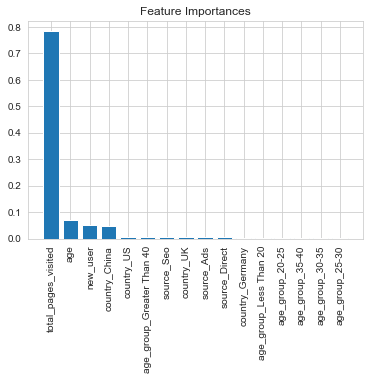

In [67]:
#Ramdom Forest
rf=RandomForestClassifier(criterion='entropy',random_state=1,n_jobs=2)
rf.fit(X_train,y_train)
features=X.columns
importances=rf.feature_importances_
indices=np.argsort(importances)[::-1]
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),importances[indices])
plt.xticks(range(X_train.shape[1]),features[indices],rotation=90)
plt.show()

#### Run predictive model

In [69]:
#Perform logistic regression
lr=LogisticRegression(C=1000.0,random_state=0)
lr.fit(X_train_std,y_train)

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [70]:
y_pred=lr.predict(X_test)

#### Evaluate Performance Metrics

confmat=confusion_matrix(y_test,y_pred)
confmat

Confusion Matrix show high rate of True Positives

In [71]:
precisionscore=precision_score(y_test,y_pred)
precisionscore

0.4812918471839307

In [72]:
recallscore=recall_score(y_test,y_pred)
recallscore

0.8108825481088254

In [73]:
f1score=f1_score(y_test,y_pred)
f1score

0.6040533860603066

In [74]:
accuracyscore=accuracy_score(y_test,y_pred)
accuracyscore

0.966223908918406

The model gives a high accuracy score of 95%.

In [94]:
#lr=LogisticRegression(C=1000.0,random_state=0)
#lr.fit(X_train_std,y_train)
log_odds = lr.coef_[0]
pd.DataFrame(log_odds, 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
total_pages_visited,2.545210
country_UK,0.446578
country_US,0.422438
country_Germany,0.287208
age_group_Greater Than 40,0.083750
source_Ads,0.033482
source_Seo,0.019837
age_group_35-40,0.008149
age_group_25-30,-0.001738
age_group_30-35,-0.008660


In [95]:
odds = np.exp(lr.coef_[0])
pd.DataFrame(odds, 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
total_pages_visited,12.745905
country_UK,1.562955
country_US,1.525676
country_Germany,1.332702
age_group_Greater Than 40,1.087357
source_Ads,1.034049
source_Seo,1.020035
age_group_35-40,1.008182
age_group_25-30,0.998263
age_group_30-35,0.991377


In [ ]:
# “For every one-unit increase in [X variable], the odds that the observation is in (y class) are [coefficient] times 
# as large as the odds that the observation is not in (y class) when all other variables are held constant.”
# As total_pages_visited increases by one unit, the odds that the user converted (the target class “1”) are over 12x 
# as large as the odds that they won’t be in the target class.

*************************************************************************************************************************

In [ ]:
#Ramdom Forest
rf=RandomForestClassifier(criterion='entropy',random_state=1,n_jobs=2)
rf.fit(X_train,y_train)
features=X.columns
importances=rf.feature_importances_
indices=np.argsort(importances)[::-1]
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),importances[indices])
plt.xticks(range(X_train.shape[1]),features[indices],rotation=90)
plt.show()

In [75]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_train,y_train)

# Actual class predictions
rf_predictions = model.predict(X_test)
# Probabilities for each class
rf_probs = model.predict_proba(X_test)[:, 1]

In [76]:
from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)

In [77]:
roc_value

0.9489565122143163

In [78]:
# Feature Importance

# Extract feature importances
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head()

,feature,importance
2,total_pages_visited,0.825255
0,age,0.070476
1,new_user,0.037968
3,country_China,0.023720
9,source_Seo,0.005641


In [81]:
rf_accuracyscore=accuracy_score(y_test,rf_predictions)
rf_accuracyscore

0.9846510647269661

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [82]:
#logistic regression performance
#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
#Accuracy
accuracy=accuracy_score(y_test,y_pred)

In [88]:
print(cm)
print("logistic regression accuracy = ",round(100*accuracy,2), "%.")

[[89212  2634]
 [  570  2444]]
logistic regression accuracy =  96.62 %.


In [89]:
#random forest performance
#Confusion matrix
rf_cm = confusion_matrix(y_test, rf_predictions)
#Accuracy
rf_accuracy=accuracy_score(y_test,rf_predictions)

In [90]:
print(rf_cm)
print("random forest accuracy = ",round(100*rf_accuracy,2), "%.")

[[91371   475]
 [  981  2033]]
random forest accuracy =  98.47 %.


random forest model (98%) has higher model acuracy than the logistic model (97%).

In [ ]:
https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1

In [92]:
# Linear Regression Coefficients
linreg = LinearRegression()
linreg.fit(X, y)
linreg.coef_
pd.DataFrame(linreg.coef_, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
# “For every one-unit increase in [X variable], the [y variable] increases by [coefficient] 
# when all other variables are held constant.”


array([[-7.24239749e-01, -7.83882333e-01,  2.54521005e+00,
        -9.99683291e-01,  2.87208250e-01,  4.46578105e-01,
         4.22437881e-01,  3.34824492e-02, -5.93874190e-02,
         1.98371786e-02, -4.07955176e-02, -3.42139309e-02,
        -1.73807119e-03, -8.66042632e-03,  8.14913288e-03,
         8.37499247e-02]])

In [ ]:
# Logistic Regression Coefficients
logreg = LogisticRegression()
logreg.fit(X, y)
log_odds = logreg.coef_[0]
pd.DataFrame(log_odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

In [ ]:
# log odd coefficients need to be converted to regular odds in order to make sense of them
odds = np.exp(logreg.coef_[0])
pd.DataFrame(odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

# “For every one-unit increase in [X variable], the odds that the observation is in (y class) are [coefficient] times 
# as large as the odds that the observation is not in (y class) when all other variables are held constant.”